# Demo of Proteus MR Thermometry
```

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
* Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
* Neither the name of the University of Calgary nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL University of Calgary, Samuel Pichardo or an of the contributors BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

This notebook illustrates the basic operation to use Proteus MR Thermometry library

Be aware some of the underlying structure for the processing is aligned how the main Proteus GUI application organizes the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from Proteus.ThermometryLibrary import ThermometryLib
from Proteus.File_IO.H5pySimple import ReadFromH5py, SaveToH5py
import tables
import logging 
from pprint import pprint
from Proteus.ThermometryLibrary.ThermometryLib import  LOGGER_NAME

from skimage import data, img_as_float
from skimage import exposure

logger = logging.getLogger(LOGGER_NAME)

stderr_log_handler = logging.StreamHandler()
logger.addHandler(stderr_log_handler)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

logger.setLevel(logging.ERROR) #use logging.INFO or logging.DEBUG for detailed step information for thermometry

stderr_log_handler.setFormatter(formatter)

logger.info(': INITIALIZING MORPHEUS application, powered by Proteus')


## Functions and classess required to prepare the MR processing

In [2]:
def CompareTwoOrderedLists(list1,list2,bPrintResults=False):
    '''
    Tool function to evaluate two MRI data collections are equivalent
    '''
    #please note NavigatorData will be empty, we kept for completeness purposes
    [IMAGES2,Navigator2]=list2
    [IMAGES,Navigator]=list1
    badimagecount = 0
    badimages = []
    badimageindex = []
    
    notallsame = False


    #Element wise comparison of two sets of results to ensure they match eachother within tolerance
    for Stack in IMAGES:
        for Map in IMAGES[Stack]:
            if Map in ['TimeArrival','SelPointsROI', 'MaskROI' ,'TemperatureROIMask']:
                continue
            for Number in range(len(IMAGES[Stack][Map])):
                for Slice in range(len(IMAGES[Stack][Map][Number])):

                    for Data in IMAGES[Stack][Map][Number][Slice]:
                        if type(IMAGES[Stack][Map][Number][Slice][Data]) is np.ndarray:
                            comparison=np.all(np.isclose(IMAGES[Stack][Map][Number][Slice][Data],
                                                  IMAGES2[Stack][Map][Number][Slice][Data]))
                            if comparison == False:
                                notallsame=True
                                if badimageindex.count(Number) == 0:
                                    badimagecount += 1
                                    badimageindex.append(Number)
                                badimages.append((badimagecount,Stack,Map,Number,Slice,Data))
                        elif type(IMAGES[Stack][Map][Number][Slice][Data]) is dict:
                            for k in IMAGES[Stack][Map][Number][Slice][Data]:
                                v1=IMAGES[Stack][Map][Number][Slice][Data][k]
                                v2=IMAGES2[Stack][Map][Number][Slice][Data][k]
                                if type(v1) is np.ndarray:
                                    comparison=np.all(np.isclose(v1,v2))
                                else:
                                    comparison=v1==v2
                                if comparison == False:
                                    notallsame=True
                                    if badimageindex.count(Number) == 0:
                                        badimagecount += 1
                                        badimageindex.append(Number)
                                    badimages.append((badimagecount,Stack,Map,Number,Slice,Data,k))
                        else:
                            comparison = (IMAGES[Stack][Map][Number][Slice][Data] == IMAGES2[Stack][Map][Number][Slice][Data])
                            if comparison == False:
                                notallsame=True
                                if badimageindex.count(Number) == 0:
                                    badimagecount += 1
                                    badimageindex.append(Number)
                                badimages.append((badimagecount,Stack,Map,Number,Slice,Data))

    

    if bPrintResults:
        if notallsame == True:
            if len(badimages)>0:
                print ('The following images did not match within tolerance')
                for e in badimages:
                    print(e)
        else:
            print('*'*40+'\nDatasets were equivalent')
    
    return notallsame==False        
    
def CreateSortedDataForProcessing(OBJ):
    '''
    The two main results to extract for processing are the images and navigator data dictionaries
    For thermometry processing , we only need to recover magnitude and phase data
    '''
    
    IMAGES=OBJ['IMAGES']
    NavigatorData=OBJ['ExtraData']['NavigatorData']
    IMAGES2 = {}
    ALL_ITEMS=[]
    for k in IMAGES:
        #this helps to initializes some empty data structures
        IMAGES2[k]={'MaskROI':[None],'SelPointsROI':[None]}
        for k2 in {'MaskROI':[None],'SelPointsROI':[None]}:
            IMAGES2[k][k2] = IMAGES[k][k2]
            
    #we reorder the data to mimic how it comes when collecting from a real MRI scanner
    for SelKey in IMAGES:
        for StackMag,StackPhase in zip(IMAGES[SelKey]['Magnitude'],IMAGES[SelKey]['Phase']):
            for ImagMag,ImagPhase in zip(StackMag,StackPhase):
                ALL_ITEMS.append(ImagMag)
                ALL_ITEMS.append(ImagPhase)
    ALL_ITEMS.extend(NavigatorData)
    #the data is organized by time of arrival, to emulate how it works during MRI data collection
    ORDERED_ITEMS = sorted(ALL_ITEMS, key=lambda k: k['TimeStamp'])
    return IMAGES2,ORDERED_ITEMS


class InspectMPSData(object):
    '''
    Minimal class to open MPS files for the re processing
    '''
    def __init__(self,fname):
        print('fname',fname)
        self.fname=fname
        self.ATables=tables.open_file(fname,'r')
        A=self.ATables

        NumberTreatments=A.root.Data.MRIONLINE._g_getnchildren()
        print("Number of treatments ",NumberTreatments)

        for treatment in A.root.Data.MRIONLINE._f_list_nodes():
             print('   '+treatment._v_name)

    def GetDataTreatment(self,iddata):
        node=self.ATables.get_node("/Data/MRIONLINE/" +iddata)
        print(node)
        return ReadOnlineMRIData(node)
    
class FieldsForImaging:
    '''
    Class containing attributes defining the parameters controlling the thermometry
    
    The values can be adjusted to test different parameter conditions
    '''
    def __init__(self):
        self.Alpha = 9.4e-09  #Thermometry temperature coefficient
        self.Beta = 3.0  # Beta Coefficient
        self.Gamma = 42580000.0  #Gyromagnetic ratio
        self.T_tolerance = 12.0  #SNR limit (*C)
        self.CorrectionOrder = 0 #Order of drift correction
        self.NumberOfAverageForReference = 4 #number of dynamics for averaging
        self.StartReference = 4  #dyn. index ref., thermometry is not calculated in dynamics prior to this #
        self.TBaseLine = 37  #Baseline temperature
        self.CalculateLargeHistory = True  #Calculate extra history
        self.UseUserDriftMask = True # use user-specified ROIs to select mask for drift corrector
        self.ROIs ='1 C 4' # string defining ROI mask for monitoring, take a look at \Proteus\Tools\parseROIString.py for details for use
        self.UserDriftROIs = '1 R 25 12 0 25' # string defining ROI mask for drift corrector, take a look at \Proteus\Tools\parseROIString.py for details for use
        #old mask settings for drift, better to UserDriftROIs instead
        self.CircleSizeFORSNRCoronal=45.0
        self.RectSizeFORSNRTransverse=110.0
        self.MaxSizeSNRRegion=200.0
        
        self.UseTCoupleForDrift = False #use this if have a setting using thermocouples to minimize excessive drift correction

        self.NumberSlicesCoronal = 1  #Number of slices in coronal stack
        self.T_mask = 38.0 #Lower limit for temperature mask
        
        #ECHO NAVIGATOR MOTION COMPENSATOR RELATED parameters
        # just kept for completeness as they are now rarely used as we do not have anymore the echonavigator patch
        self.UseMotionCompensation = False  #Use Motion Compensation, keep this FALSE unless you have a dataset with echo navigator
        self.TimeBeforeFilterNavigator = 10.0  #time before filtering (s)
        self.OrderForPredictor = 5  #Order of predictor
        self.DiscardedPointsInPredictor = 100  #Tail points to ignore
        self.AmplitudeCriteriaForRestMotion = 25.0 # ampl. limit for motion-less detection (%)
        self.TimeWindowForClassification = 11  #time window for class. (s)
        self.TimeWindowForFiltering = 100  #time window for filter. (s)
        self.NumberPointsInterpolateInitialLUT = 100  #Number of points for interpolation fir
        self.NumberNavMessagesToWait = 0 #Number of Navigator messages to wait for
        self.TimeWindowtoKeepInLUT = 175.0  #'Length of window (s) of entries to keep in LUT'
        self.FrequencyCut = 0.8  #Frequency cutoff for butterworth filter (Hz)
        

#Empty Main object to preserve the structure required by thermometrylib
class MainObject: pass

class UnitTest:
    def __init__(self):
        #setting up supporting structures required to perform thermometry
        self.ImagingFields=FieldsForImaging()

        self.MainObject = MainObject()
        self.MainObject.TemporaryData = {}
        self.MainObject.TemporaryData['NavigatorDisplacement']=[]
        self.MainObject.TemporaryData['FilterForNavigator']=[]
        self.MainObject.NavigatorData=[]
        self.MainObject.ImagesKeyOrder=['Coronal','Sagittal','User1','User2']
        self.MainObject.IMAGES={}
        for k in self.MainObject.ImagesKeyOrder:
            self.MainObject.IMAGES[k]={'Magnitude':[],'Phase':[],'Temperature':[],'Dose':[],'MaskROI':[None],'SelPointsROI':[None],
                                        'TemperatureROIMask':[None]}
            self.MainObject.TemporaryData[k]=[]
        self.POOL_SIZE=10000
        self.POOL_TIME_NAV=np.zeros(self.POOL_SIZE)
        self.POOL_DATA_NAV=np.zeros(self.POOL_SIZE)
        self.POOL_FILT_DATA_NAV=np.zeros(self.POOL_SIZE)
        self.POOL_MOTIONLESS=np.ones(self.POOL_SIZE)*np.nan
        self.POOL_INHALATION=np.ones(self.POOL_SIZE)*np.nan
        self.POOL_EXHALATION=np.ones(self.POOL_SIZE)*np.nan
        self.POOL_FILT_DATA_CLASS=np.zeros(self.POOL_SIZE)
        self.POOL_DATA_INDEX=0

        self.BackPointsToRefresh=200
        self.TotalImages = 0
        self.BottomIndexForFiltering=0
        self.TProcessor={}
        self.InBackground = False
        self.cback_UpdateTemperatureProfile = lambda x: None
        self.cback_UpdateNavigatorDisplacementProfile = lambda: None
        self.cback_UpdateMRIImage = lambda x,y,z: None
        self.cback_LockMutex = lambda x: None
        self.cback_LockList = lambda x: None
        self.IncreaseCounterImageProc = lambda: None
        self.MaxSlicesPerDynamicProc =  lambda: 1 #THIS IS ONLUY VALID FOR DATA COLLECTIONS WITH 1 slice per dyanmic
        self.GetStackFromSliceNumberFunc =  lambda x: (0,0)
        self.NumberSlicesStackFunc = lambda x: 1 #THIS IS ONLUY VALID FOR DATA COLLECTIONS WITH 1 slice per dyanmic
        self.ReleaseOnlyNavigatorProc = lambda: None
            
    
    def ReturnElementsToInitializeprocessor(self):
        '''
        This function prepares a minimal 
        '''
        MO=self.MainObject
        return [MO.IMAGES,
                MO.TemporaryData,
                MO.NavigatorData,
                MO.ImagesKeyOrder,
                self.IncreaseCounterImageProc,
                self.MaxSlicesPerDynamicProc,
                self.GetStackFromSliceNumberFunc,
                self.NumberSlicesStackFunc,
                self.ReleaseOnlyNavigatorProc]
            
    def BatchProccessor(self, inputdata):
        '''
        This function reprocess all the magnitude and phase data to recreate a new data collection including thermometry data
        '''
        #add input data to parent
        [IMAGES2,self.MainObject.ORDERED_ITEMS] = CreateSortedDataForProcessing(inputdata)
        self.MainObject.MinTime = self.ep.GetReferenceTime()
        #process entries one by one
        for NewEntry in self.MainObject.ORDERED_ITEMS:

            if 'info' in NewEntry:
                self.ep.ProcessImage(NewEntry)
                self.TotalImages+=1

            else:
                self.ep.ProcessNavigator(NewEntry)
                self.TotalImages+=1

        return [self.MainObject.IMAGES,self.MainObject.NavigatorData]
 

## Read demo data and plt.time('Time (s)')process
This demo data is for a single slice/dynamic scan. Data was collected with a 3T GE MRI scanner (Discvoery 750) with the following MR params:
* Single-slice spoiled gradient-echo sequence 
* TR/TE=28/13 ms
* flip angle=30°
* FOV=28 cm
* slice thickness=3 mm
* matrix=256×128

The total duration of the scan for thermometry was 975 s, with a frame rate of 2.24s and 436 dynamics in total

In [3]:
OriginalImagingData=ReadFromH5py('DemoData.hdf5')

We can inspect the data as it would have come from an MRI scanner

The data is assumed to be prepare by any of the pyMRI services that prepares the imaging data in magnitude and phase regardless if at the source is real+imaginary

In [4]:
[_,ORDERED_ITEMS] = CreateSortedDataForProcessing(OriginalImagingData)
print('Total number of images (both magnitude and phase) =',len(ORDERED_ITEMS))

Total number of images (both magnitude and phase) = 872


In [5]:
pprint(ORDERED_ITEMS[0]) #Put attention to the metadata IsPhaseImage as False, this indicates this is a Magnitude map

{'ExposureID': 1,
 'MainID': 0,
 'TimeID': 1593545149.760632,
 'TimeStamp': 1593545149.760632,
 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32),
 'info': {'DynamicAcquisitionTime': 1593545149.6464,
          'DynamicLevel': 0,
          'EchoTime': 0.013099999999999999,
          'IsPhaseImage': False,
          'OffcentreAnteriorPosterior': -0.1904129936,
          'OffcentreFeetHead': 0.0184,
          'OffcentreRightLeft': -0.1478129936,
          'RescaleIntercept': 0.0,
          'RescaleSlope': 1.0,
          'ScaleIntercept': 0.0,
          'ScaleSlope': 1.0,
          'SliceNumber': 0,
          'SlicePrepulseDelay': 0,
          'VoxelSize': array([0.0010938, 0.0010938, 0.003    ])}}


In [6]:
pprint(ORDERED_ITEMS[1]) #the second image in the collection is the phase data

{'ExposureID': 0,
 'MainID': 1,
 'TimeID': 0.0,
 'TimeStamp': 1593545149.760692,
 'data': array([[-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       ...,
       [-0.       , -0.       , -1.815775 , ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -1.5707964, ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -1.5707964, ..., -0.       , -0.       ,
        -0.       ]], dtype=float32),
 'info': {'DynamicAcquisitionTime': 1593545149.6467369,
          'DynamicLevel': 0,
          'EchoTime': 0.013099999999999999,
          'IsPhaseImage': True,
          'OffcentreAnteriorPosterior': -0.1904129936,
          'OffcentreFeetHead': 0.0184,
          'OffcentreRightLeft': -0.1478129936,
          'Resc

In [6]:
pprint(ORDERED_ITEMS[2]) #the third image in the collection is the magnitude data of a new dynamic, you can see the DynamicLevel was changed to 1


{'ExposureID': 0,
 'MainID': 4096,
 'TimeID': 0.0,
 'TimeStamp': 1593545151.8890991,
 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 6., ..., 0., 0., 0.],
       [0., 0., 6., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32),
 'info': {'DynamicAcquisitionTime': 1593545151.8833401,
          'DynamicLevel': 1,
          'EchoTime': 0.013099999999999999,
          'IsPhaseImage': False,
          'OffcentreAnteriorPosterior': -0.1904129936,
          'OffcentreFeetHead': 0.0184,
          'OffcentreRightLeft': -0.1478129936,
          'RescaleIntercept': 0.0,
          'RescaleSlope': 1.0,
          'ScaleIntercept': 0.0,
          'ScaleSlope': 1.0,
          'SliceNumber': 0,
          'SlicePrepulseDelay': 0,
          'VoxelSize': array([0.0010938, 0.0010938, 0.003    ])}}


----
We use the UnitTest class for demonstration to reprocess MRI data

In [7]:
ut = UnitTest() #Instantiate a parent class
ut.ep = ThermometryLib.EntryProcessing(*ut.ReturnElementsToInitializeprocessor()) #Instantiate an entry processor member on the parent class
ut.ep.ImagingFields = ut.ImagingFields #Instantiate a class full of image processing parameters

We print the original parameters for thermometry processing

In [8]:
for k in dir(ut.ep.ImagingFields):
    if '_' not in k:
        print(k,OriginalImagingData['ExtraData']['ImagingFields'][k])
        setattr(ut.ep.ImagingFields,k,OriginalImagingData['ExtraData']['ImagingFields'][k])

Alpha 9.4e-09
AmplitudeCriteriaForRestMotion 25.0
Beta 3.0
CalculateLargeHistory True
CircleSizeFORSNRCoronal 45.0
CorrectionOrder 0
DiscardedPointsInPredictor 100
FrequencyCut 0.8
Gamma 42580000.0
MaxSizeSNRRegion 200.0
NumberNavMessagesToWait 20
NumberOfAverageForReference 4
NumberPointsInterpolateInitialLUT 200
NumberSlicesCoronal 1
OrderForPredictor 5
ROIs 1 C 4
RectSizeFORSNRTransverse 110.0
StartReference 4
TBaseLine 37.0
TimeBeforeFilterNavigator 20.0
TimeWindowForClassification 11
TimeWindowForFiltering 100
TimeWindowtoKeepInLUT 200.0
UseMotionCompensation False
UseTCoupleForDrift 0
UseUserDriftMask True
UserDriftROIs 1 R 25 12 0 25


We reprocess the magntiude and phase data. We also use the CompareTwoOrderedLists to show that the repreocess thermometry is the same as in the original dataset

In [9]:
newdata = ut.BatchProccessor(OriginalImagingData) #Parent class must posses a method directing the processing of entries
res=CompareTwoOrderedLists(newdata,(OriginalImagingData['IMAGES'],OriginalImagingData['ExtraData']['NavigatorData'])) #Compare the results to ensure that
print(res)

True


We now can plot the different imaging data (magnitude, phase, thermal and supportive mask)

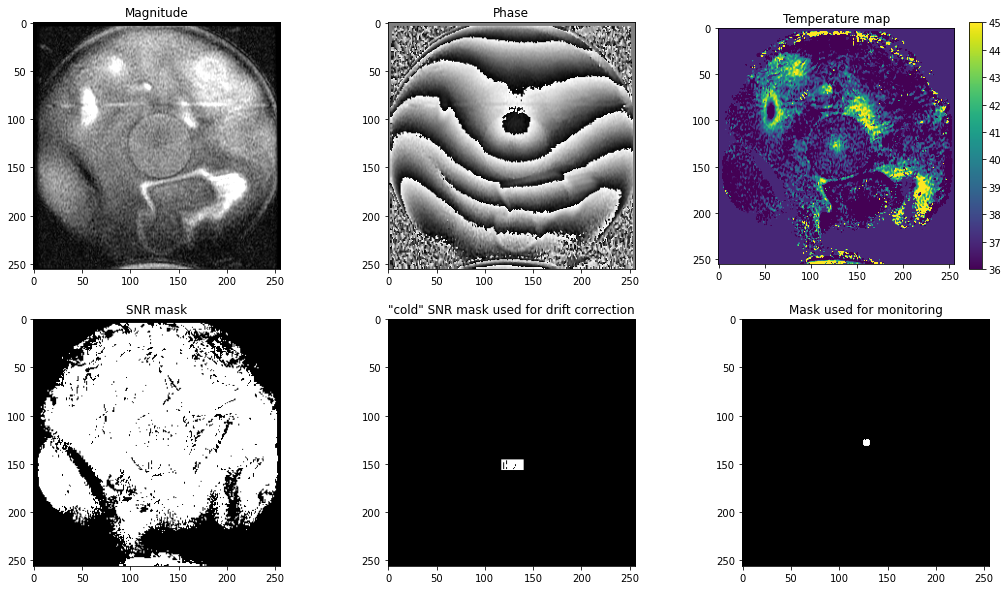

In [10]:
Main=ut.MainObject

def PlotImages(nDynamic, Main):
    IMAGES=Main.IMAGES
    plt.figure(figsize=(18,10))
    plt.subplot(2,3,1)
    p2, p98 = np.percentile(IMAGES['Coronal']['Magnitude'][nDynamic][0]['data'], (2, 98))
    img_rescale = exposure.rescale_intensity(IMAGES['Coronal']['Magnitude'][nDynamic][0]['data'], in_range=(p2, p98))
    plt.imshow(img_rescale,cmap=plt.cm.gray)
    plt.title('Magnitude')
    plt.subplot(2,3,2)
    plt.imshow(IMAGES['Coronal']['Phase'][nDynamic][0]['data'],cmap=plt.cm.gray)
    plt.title('Phase')
    plt.subplot(2,3,3)
    plt.imshow(IMAGES['Coronal']['Temperature'][nDynamic][0]['data'],vmin=36,vmax=45)
    plt.colorbar()
    plt.title('Temperature map')
    
    plt.subplot(2,3,4)
    plt.imshow(IMAGES['Coronal']['Temperature'][nDynamic][0]['SNR_Mask'],cmap=plt.cm.gray)
    plt.title('SNR mask')
    plt.subplot(2,3,5)
    plt.imshow(IMAGES['Coronal']['Temperature'][nDynamic][0]['SNR_ColdMask'],cmap=plt.cm.gray)
    plt.title('"cold" SNR mask used for drift correction')
    plt.subplot(2,3,6)
    #note that the mask for ROI monitoring is constant accross all image and it is stored in the TemporaryData
    plt.imshow(Main.TemporaryData['Coronal'][0]['MaskAverage'],cmap=plt.cm.gray)
    plt.title('Mask used for monitoring')
    
PlotImages(60,Main)# we plot at dynamic # 60


`Main.TemporaryData` has also the temperature profile over time resulting from the thermometry in the user ROI

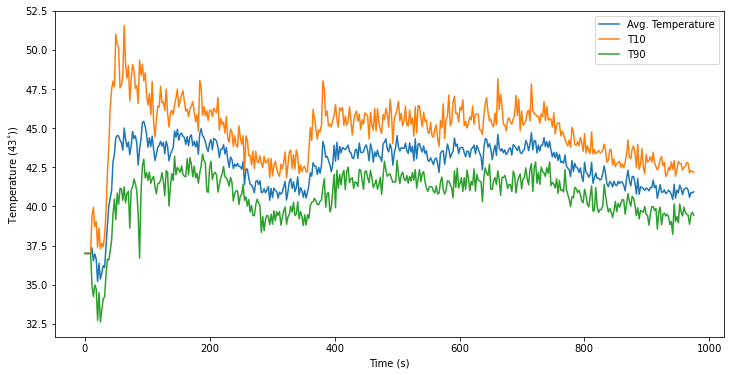

In [11]:
def PlotTemporalData(Main):
    timeD=np.array(Main.TemporaryData['Coronal'][0]['TimeTemperature'])
    AvgTemp=np.array(Main.TemporaryData['Coronal'][0]['AvgTemperature'])
    T10=np.array(Main.TemporaryData['Coronal'][0]['T10'])
    T90=np.array(Main.TemporaryData['Coronal'][0]['T90'])
    plt.figure(figsize=(12,6))
    plt.plot(timeD,AvgTemp)
    plt.plot(timeD,T10)
    plt.plot(timeD,T90)
    plt.legend(['Avg. Temperature','T10','T90'])
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (43$^{\circ}$))')

PlotTemporalData(Main)

## Re process data changing a couple parameters
We prepare again the processing but we change on purpose the Baseline temperature and the location of the user ROI

In [12]:
ut2 = UnitTest() #Instantiate a parent class
ut2.ep = ThermometryLib.EntryProcessing(*ut2.ReturnElementsToInitializeprocessor()) #Instantiate an entry processor member on the parent class
ut2.ep.ImagingFields = ut2.ImagingFields #Instantiate a class full of image processing parameters
for k in dir(ut2.ep.ImagingFields):
    if '_' not in k:
        print(k,OriginalImagingData['ExtraData']['ImagingFields'][k])
        setattr(ut2.ep.ImagingFields,k,OriginalImagingData['ExtraData']['ImagingFields'][k])
ut2.ep.ImagingFields.TBaseLine = 40 # we change from 37 to 40
ut2.ep.ImagingFields.ROIs = '1 C 4 -12 0' # it is still a cirlce of radius 4 mm but we shift it 12 mm to the left

Alpha 9.4e-09
AmplitudeCriteriaForRestMotion 25.0
Beta 3.0
CalculateLargeHistory True
CircleSizeFORSNRCoronal 45.0
CorrectionOrder 0
DiscardedPointsInPredictor 100
FrequencyCut 0.8
Gamma 42580000.0
MaxSizeSNRRegion 200.0
NumberNavMessagesToWait 20
NumberOfAverageForReference 4
NumberPointsInterpolateInitialLUT 200
NumberSlicesCoronal 1
OrderForPredictor 5
ROIs 1 C 4
RectSizeFORSNRTransverse 110.0
StartReference 4
TBaseLine 37.0
TimeBeforeFilterNavigator 20.0
TimeWindowForClassification 11
TimeWindowForFiltering 100
TimeWindowtoKeepInLUT 200.0
UseMotionCompensation False
UseTCoupleForDrift 0
UseUserDriftMask True
UserDriftROIs 1 R 25 12 0 25


----
We compared to the original dataset, now it should return they are not equal

In [ ]:
newdata2 = ut2.BatchProccessor(OriginalImagingData) #Parent class must posses a method directing the processing of entries
res2=CompareTwoOrderedLists(newdata2,(OriginalImagingData['IMAGES'],OriginalImagingData['ExtraData']['NavigatorData'])) #Compare the results to ensure that
print(res2)

When plotting the several maps at the same location, we can see the thermal maps show higher temperature as we changed the the

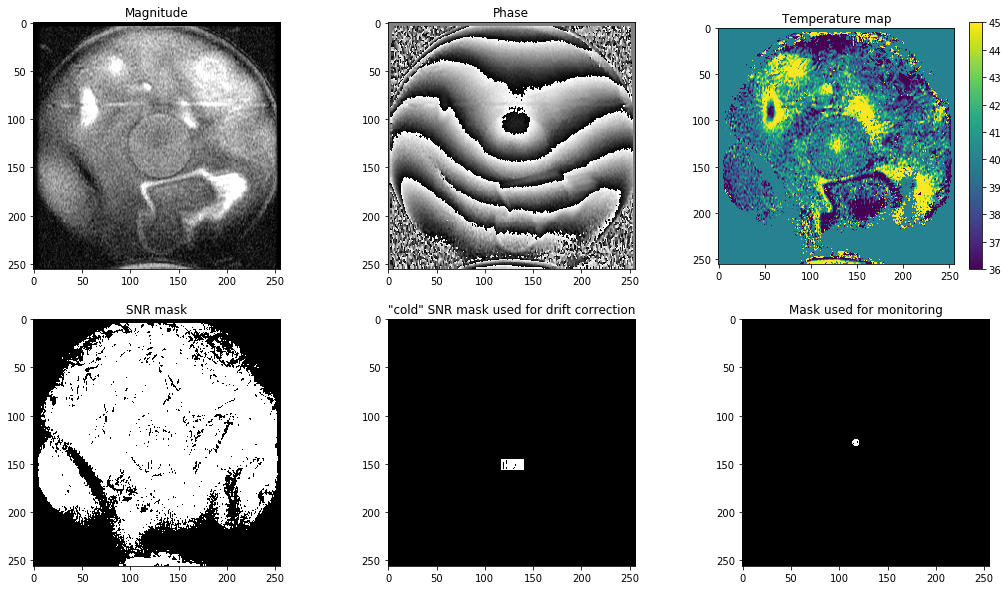

In [15]:
Main2=ut2.MainObject

PlotImages(60,Main2)# we plot at dynamic # 60

And finally, the plot of the updated ROI  shows now the temperature profile of an ROI 12 mm to the left of the focal spot

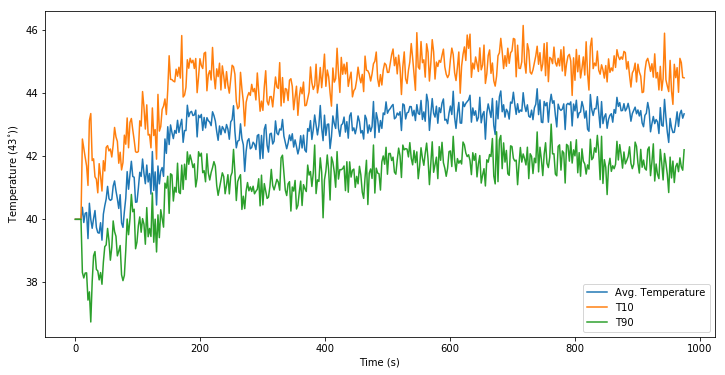

In [16]:
PlotTemporalData(Main2)